In [1]:
import numpy as np
import tushare as ts
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

In [2]:
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

In [3]:
pro = ts.pro_api(os.environ['TUSHARE_API_TOKEN'])

In [4]:
start = '20210801'                 # 回测起始时间
end = '20210831'                   # 回测结束时间
bdsr_month = 3.85 # 被动收入月涨幅%

In [5]:
def generate_date_range(start, end):
    return [datetime.strftime(x,'%Y%m%d') for x in list(pd.date_range(start=start, end=end))]

In [6]:
def fill_none_trade_data(data):
    # 使用第一个交易日行情补全第一个交易日之前的行情数据
    first_trade_date_l = generate_date_range(date_l[0], list(data['trade_date'])[0])
    if len(first_trade_date_l) > 1:
        for i in first_trade_date_l[::-1][1::]:
            data = data.append(data.loc[data['trade_date'] == first_trade_date_l[-1]].assign(trade_date=i), ignore_index=True)
    # 使用前一日行情补全非交易日的行情数据
    for idx, val in enumerate(date_l):
        if data.loc[data['trade_date'] == val].empty:
            data = data.append(data.loc[data['trade_date'] == date_l[idx-1]].assign(trade_date=val), ignore_index=True)
    # 重排序
    data = data.sort_values(by='trade_date', ascending=True)
    data = data.reset_index(drop=True)
    return data

In [7]:
date_l = generate_date_range(start, end)

In [8]:
hs300_data = fill_none_trade_data(pro.index_daily(ts_code='000300.SH', start_date=start, end_date=end).sort_index(ascending=False)) # 沪深300
zz500_data = fill_none_trade_data(pro.index_daily(ts_code='000905.SH', start_date=start, end_date=end).sort_index(ascending=False)) # 中证500
cyb_data = fill_none_trade_data(pro.index_daily(ts_code='399006.SZ', start_date=start, end_date=end).sort_index(ascending=False)) # 创业板

In [9]:
hsi_data = fill_none_trade_data(pro.index_global(ts_code='HSI', start_date=start, end_date=end).sort_index(ascending=False)) # 恒生
spx_data = fill_none_trade_data(pro.index_global(ts_code='SPX', start_date=start, end_date=end).sort_index(ascending=False)) # 标普500
ixic_data = fill_none_trade_data(pro.index_global(ts_code='IXIC', start_date=start, end_date=end).sort_index(ascending=False)) # 纳斯达克

In [10]:
def draw_index_change(ax, index_data, start_index, time, name, index_month):
    change = (index_data/start_index - 1) * 100
    ax.plot(time, change, label=name)
    for i,j in zip(time,change):
        if i == time[-1]:
            index_month.append(j)
            ax.annotate("{:10.2f}".format(j),xy=(i,j))

In [11]:
index_month = []
time=np.array(hs300_data['trade_date'])

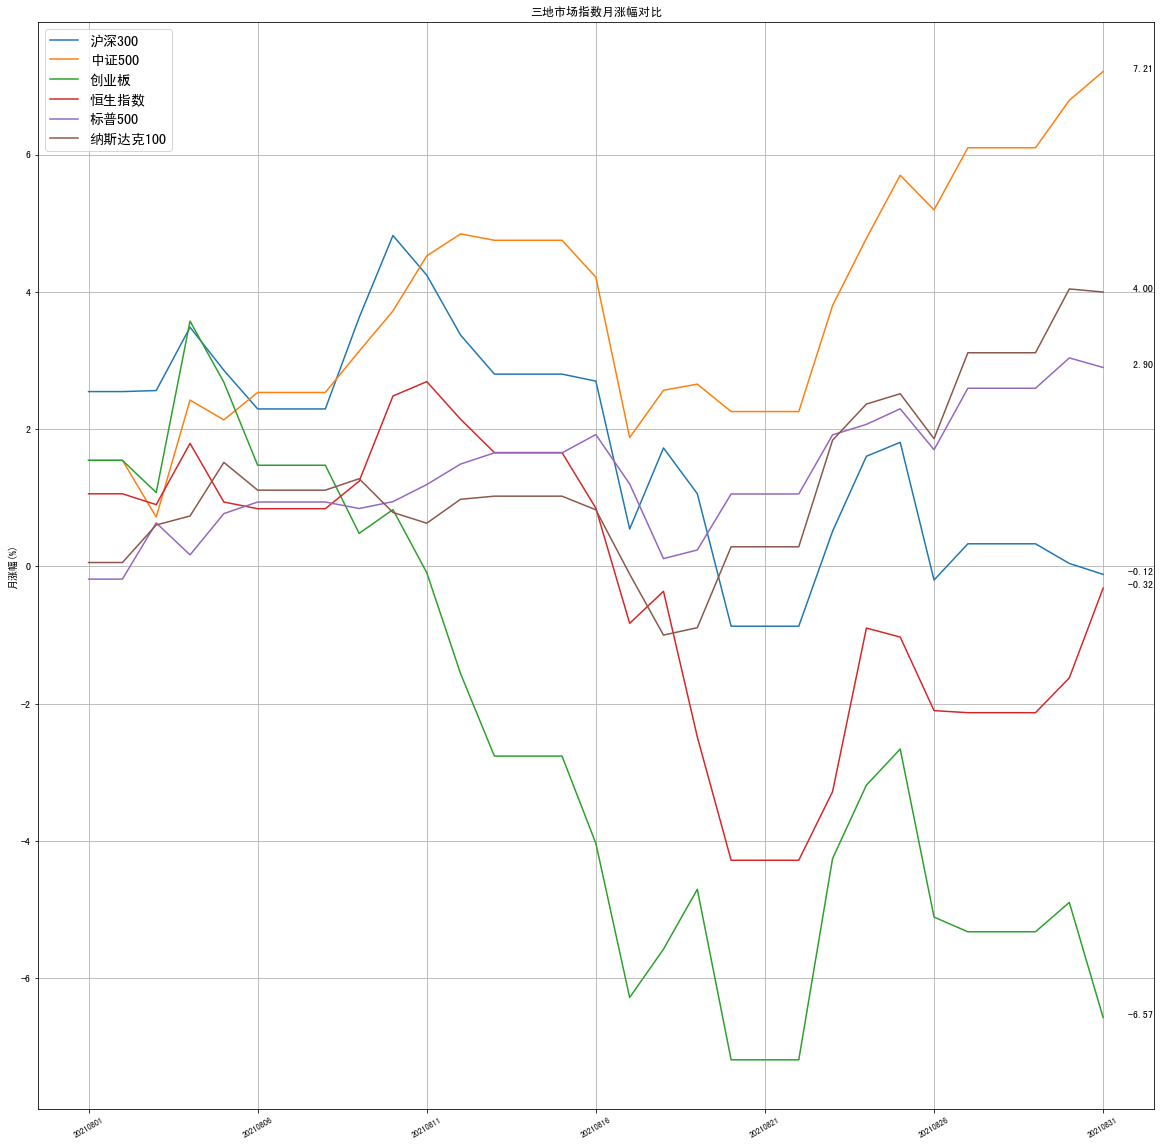

In [12]:
fig,ax=plt.subplots(figsize=(20,20))
draw_index_change(ax, np.array(hs300_data['close']), np.array(hs300_data['pre_close'])[0], np.array(hs300_data['trade_date']), '沪深300', index_month)
draw_index_change(ax, np.array(zz500_data['close']), np.array(zz500_data['pre_close'])[0], np.array(zz500_data['trade_date']), '中证500', index_month)
draw_index_change(ax, np.array(cyb_data['close']), np.array(cyb_data['pre_close'])[0], np.array(cyb_data['trade_date']), '创业板', index_month)
draw_index_change(ax, np.array(hsi_data['close']), np.array(hsi_data['pre_close'])[0], np.array(hsi_data['trade_date']), '恒生指数', index_month)
draw_index_change(ax, np.array(spx_data['close']), np.array(spx_data['pre_close'])[0], np.array(spx_data['trade_date']), '标普500', index_month)
draw_index_change(ax, np.array(ixic_data['close']), np.array(ixic_data['pre_close'])[0], np.array(ixic_data['trade_date']), '纳斯达克100', index_month)
ax.legend(loc='best', prop=fontP)
ax.grid(True)
ax.set_xticks([time[i] for i in range(0,len(time),5)])
ax.set_ylabel('月涨幅(%)', fontname='SimHei')
ax.set_title('三地市场指数月涨幅对比', fontname='SimHei')
plt.xticks(rotation=30,fontsize='small')
plt.show()

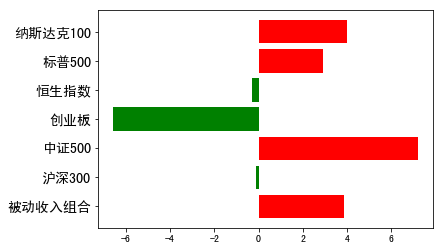

In [13]:
name_list = ['被动收入组合', '沪深300','中证500','创业板','恒生指数', '标普500', '纳斯达克100']
index_month.insert(0, bdsr_month)
colors = ['r' if i >=0 else 'g' for i in index_month]
plt.barh(range(len(index_month)), index_month, color = colors, tick_label=name_list)
plt.yticks(range(len(index_month)), name_list, fontproperties=fontP)
plt.show()